In [ ]:
import os, sys
sys.path.insert(0, os.path.abspath("../scr"))
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from sbi import analysis as analysis
from sbi.inference import prepare_for_sbi

In [ ]:
from simulator import smfe_simulator_mm
from gls_spline import gls_spline
import config

In [ ]:
@np.vectorize
def G0(x):
    if abs(x) > 0.5:
        return 2 * (np.abs(x) - 1) ** 2 - 1
    else:
        return -2 * x ** 2

In [ ]:
x_knots = np.linspace(config.min_x, config.max_x, config.N_knots)
y_knots_true = np.zeros(config.N_knots)
y_knots_true[0] = y_knots_true[-1] = config.max_G_0
y_knots_true[1] = y_knots_true[-2] = config.max_G_1
y_knots_true[2] = 5
y_knots_true[3] = 1
y_knots_true[4] = 4
y_knots_true[5] = 5
y_knots_true[6] = 4
y_knots_true[7] = 4
y_knots_true[8] = 7
y_knots_true[9] = 3
y_knots_true[10] = 2
y_knots_true[11] = 1
y_knots_true[12] = 5

In [ ]:
sliders = []
for i in range(config.N_knots_prior):
    sliders.append(
        widgets.FloatSlider(
            name=f'Node : {i}', 
            value= 8 * G0(x_knots[i+2]/1.5) + 7, 
            min=config.spline_lims[0],
            max=config.spline_lims[1],
            step=0.1,
            orientation='vertical',
            readout_format='.1f'
        )
    )

In [ ]:
widgets.HBox(sliders)

In [ ]:
for i in range(config.N_knots_prior):
    y_knots_true[i + (config.N_const_knots // 2)] = sliders[i].value

In [ ]:
x_axis = np.linspace(config.min_x, config.max_x, 1000)
true_y = gls_spline(x_knots, y_knots_true, x_axis)

In [ ]:
plt.plot(x_axis, true_y, label='Spline')
plt.plot(x_knots, y_knots_true, 'ob', label='Nodes')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$G_0(x)$', fontsize=18)
plt.legend(fontsize=14)
plt.ylim(0, 20)
plt.grid(True)

In [ ]:
observation = smfe_simulator_mm(true_params)

In [ ]:
f = observation.view(6, 20, 20)
fig, axes = plt.subplots(1, 6, figsize=(20, 40))
for i in range(6):
    axes[i].imshow(f[i])

In [ ]:
with open(f'../scr/test_timing.pkl', 'rb') as handle:
    posterior = pickle.load(handle)

In [ ]:
posterior.set_default_x(observation.to('cuda'))
map_params = posterior.map(num_init_samples=100000, num_to_optimize=100, init_method='posterior', show_progress_bars=True)
samples = posterior.sample((1000000,))

In [ ]:
samples = posterior.sample((1000000,), x=observation)

In [ ]:
# Removing shifts along y-axis
samples[:, 2:] = samples[:, 2:] - torch.mean(samples[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_params[2:])

In [ ]:
labels = [r'$D_q/D_x$', r'$\kappa$', *[f'Spline {i}' for i in range(11)]]
limits = [config.logD_lims, config.k_lims, *[config.spline_lims for i in range(11)]]
_ = analysis.pairplot(samples.cpu(), figsize=(20, 20), points=true_params, points_offdiag={'markersize': 6}, points_colors='r', labels=labels)

In [ ]:
_ = analysis.marginal_plot(samples.cpu(), points=true_params, points_colors='r', figsize=(32, 2))

In [ ]:
# Plotting individual posterior samples
for sample in samples[torch.randperm(100000)[:1000]].cpu():
    y_knots = config.max_G_0 * np.ones(config.N_knots)
    y_knots[1] = y_knots[-2] = 30
    y_knots[2:-2] = sample[2:].numpy()
    y_axis = gls_spline(x_knots, y_knots, x_axis)
    plt.plot(x_axis, y_axis, alpha=0.02, color='blue')
    plt.ylim(-2, 20)
    plt.xlim(-5, 5)
plt.title(f'log(Dq/Dx) = {D}, $\kappa_l = {k}$')
plt.plot(x_axis, true_y, color='red', linewidth=1.6, label='ground truth')
plt.xlabel(r'Molecular extension x', fontsize=18)
plt.ylabel(r'$G_0(x)$', fontsize=18)
plt.legend(loc='upper left')
plt.grid(True)

In [ ]:
# Plotting the posterior mean
mean_posterior = torch.mean(samples.cpu(), dim=0)

y_axis = gls_spline(x_knots, y_knots, x_axis)
plt.plot(x_axis, true_y, color='red', linewidth=1.6, label='ground truth')

y_knots = config.max_G_0 * np.ones(config.N_knots)
y_knots[1] = y_knots[-2] = 30
y_knots[2:-2] = mean_posterior[2:].numpy()
y_knots_err = np.zeros((2, config.N_knots))
y_knots_err[:, 2:-2] = np.abs(np.quantile(samples.cpu().numpy(), [0.05, 0.95], axis=0)[:, 2:] - mean_posterior[2:].numpy())
y_axis = gls_spline(x_knots, y_knots, x_axis)
plt.plot(x_axis, y_axis, alpha=1, color='blue')
plt.errorbar(x_knots, y_knots, yerr=y_knots_err, linestyle='', marker='o', color='blue', label='posterior mean')

plt.title(f'log(Dq/Dx) = {D}, $\kappa_l$ = {k}')
plt.xlabel(r'Molecular extension x', fontsize=18)
plt.ylabel(r'$G_0(x)$', fontsize=18)
plt.legend(loc='upper left', fontsize=14)
plt.ylim(0, 17)
plt.xlim(-6, 6)
plt.grid(True)

In [ ]:
# Plotting the posterior map
y_knots = config.max_G_0 * np.ones(config.N_knots)
y_knots[2:-2] = map_params[2:] - torch.mean(map_params[2:]) + torch.mean(true_params[2:])
y_knots[1] = y_knots[-2] = 30
y_axis = gls_spline(x_knots, y_knots, x_axis)
plt.plot(x_axis, y_axis, color='blue',linewidth=1.6 ,label='MAP')
plt.plot(x_knots, y_knots, linestyle='', marker='o', color='blue')
plt.plot(x_axis, true_y, color='red', linewidth=1.6, label='ground truth')
plt.ylim(0, 17)
plt.xlim(-6, 6)
plt.legend()
plt.title(f'log(Dq/Dx) = {D}, \kappa_l = {k}')
plt.xlabel(r'Molecular extension x', fontsize=18)
plt.ylabel(r'$G_0(x)$', fontsize=18)
plt.grid(True)

In [ ]:
import scipy.stats as stats
def generate_kde(samples, limits):
    kde_xs = np.linspace(limits[0], limits[1], 300)
    kde = stats.gaussian_kde(samples)
    return kde_xs, kde.pdf(kde_xs)

In [ ]:
x = 4
fig = plt.figure(figsize=(3*x, 2*x))

ax3 = plt.subplot2grid((3, 3), (0, 0), colspan=2, rowspan=2)
ax1 = plt.subplot2grid((3, 3), (2, 0))
ax2 = plt.subplot2grid((3, 3), (2, 1))

confidence_intervall = np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)
confidence_mass = [
    generate_kde(
        samples[:, i], confidence_intervall[:, i]
    ) 
    for i in range(2)
]

ax1.plot(*generate_kde(samples.cpu()[:, 0].numpy(), config.logD_lims), linewidth=2)
ax1.set_yticklabels([])
#ax1.set_ylabel('$p(D_q/D_x|q_t)$', fontsize=18)
ax1.set_xlabel('$log_{10}(D_q/D_x)$', fontsize=18)
ax1.tick_params(axis='both', which='major', labelsize=14)
axins = ax1.inset_axes((0.4, 0.5, 0.55, 0.4))
axins.axvline(x=D, ymin=0, ymax=1, color='r')
axins.plot(*generate_kde(samples.cpu()[:, 0].numpy(), (-1.02, -0.98)), linewidth=2)
axins.set_yticklabels([])
axins.fill_between(*confidence_mass[0], color='blue', alpha=0.2)

ax2.plot(*generate_kde(samples.cpu()[:, 1].numpy(), config.k_lims), linewidth=2)
ax2.set_yticklabels([])
#ax2.set_ylabel('$p(\kappa_l|q_t)$', fontsize=18)
ax2.set_xlabel(r'$\kappa_l$ [$k_{\mathrm{B}}T/[q]^2$]', fontsize=18)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax2.axvline(x=k, ymin=0, ymax=1, color='r')
ax2.fill_between(*confidence_mass[1], color='blue', alpha=0.2)

y_knots = config.max_G_0 * np.ones(config.N_knots)
y_knots[2:-2] = mean_posterior[2:].cpu().numpy()
y_knots[1] = y_knots[-2] = 30
y_knots_err[:, 2:-2] = np.abs(np.quantile(samples.cpu().numpy(), [0.16, 0.84], axis=0)[:, 2:] - mean_posterior[2:].numpy())
y_axis = gls_spline(x_knots, y_knots, x_axis)
ax3.plot(x_axis, true_y, color='red', linewidth=2., label='Ground truth', alpha=0.8)
ax3.errorbar(x_knots, y_knots, yerr=y_knots_err, linestyle='', marker='o', color='blue', label='posterior mean', alpha=0.8)
ax3.plot(x_axis, y_axis, color='blue',linewidth=2. ,label='Inference (Mean)', alpha=0.8)
#ax3.plot(x_knots, y_knots, linestyle='', marker='o', color='blue')
for hline in np.arange(-0, 16, 1):
    ax3.axhline(hline, -3.5, 3.5, linestyle=':', color='gray')
ax3.set_xlabel('Molecular extension x', fontsize=18)
ax3.set_ylabel(r'$G_0(x)$ [$k_{\mathrm{B}}T$]', fontsize=18)
ax3.set_ylim(-0, 10)
ax3.set_xlim(-5, 5)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.legend(fontsize=14)
plt.tight_layout()
#plt.savefig('spline_potential.pdf', dpi=500)

In [ ]:
from matplotlib.lines import Line2D

In [ ]:
k_unit = '$[k_{\mathrm{B}}T]/[q]^2$'
legend_handles = [Line2D([0], [1], color='red', lw=2.5), Line2D([0], [1], color='blue', lw=2.5)]
img_counter = 0
for D in [-1.8, -1, 0]:
    for k in [2, 3, 4]:
        true_params = torch.tensor([D, k, *y_knots_true[2: -2]])
        observation = smfe_simulator_mm(true_params)
        samples = posterior.sample((100000,), x=observation)
        samples[:, 2:] = samples[:, 2:] - torch.mean(samples[:, 2:], dim=1).reshape(-1, 1) + torch.mean(true_params[2:])
        for sample in samples[torch.randperm(100000)[:500]].cpu():
            y_knots = config.max_G_0 * np.ones(config.N_knots)
            y_knots[1] = y_knots[-2] = 30
            y_knots[2:-2] = sample[2:].numpy()
            y_axis = gls_spline(x_knots, y_knots, x_axis)
            plt.plot(x_axis, y_axis, alpha=0.01, color='blue', linewidth=0.68)
        plt.ylim(-2, 20)
        plt.xlim(-5, 5)
        for hline in np.arange(-0, 20, 5):
            plt.hlines(hline, -5, 5, linestyle=':', color='gray', zorder=0)
        plt.tick_params(labelsize=14)
        plt.title(f'log($D_q/D_x$) = {D},  $\kappa_l = {k}$ {k_unit}', fontsize=16)
        plt.plot(x_axis, true_y, color='red', linewidth=1.6, label='Ground truth')
        plt.xlabel(r'Molecular extension x', fontsize=18)
        plt.ylabel(r'$G_0(x)~[k_{\mathrm{B}}T]$', fontsize=18)
        plt.legend(legend_handles, ['Ground truth', 'Posterior samples'], loc='upper center', fontsize=15)
        #plt.show()
        plt.savefig(f'spline_SI_{img_counter}.pdf', dpi=500, bbox_inches='tight')
        img_counter += 1

In [1]:
from sbi_smfs.inference.priors import get_priors_from_config

/Users/lars/Miniconda/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
prior = get_priors_from_config('../tests/test.config')

In [3]:
samples = prior.sample((100000,))

In [4]:
from sbi_smfs.analysis.plot_posterior import plot_spline_ensemble, plot_spline_mean_with_error

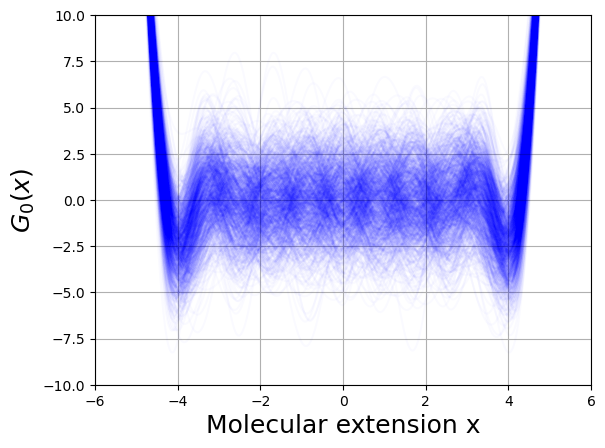

In [5]:
plot_spline_ensemble(samples, 1000, '../tests/test.config')

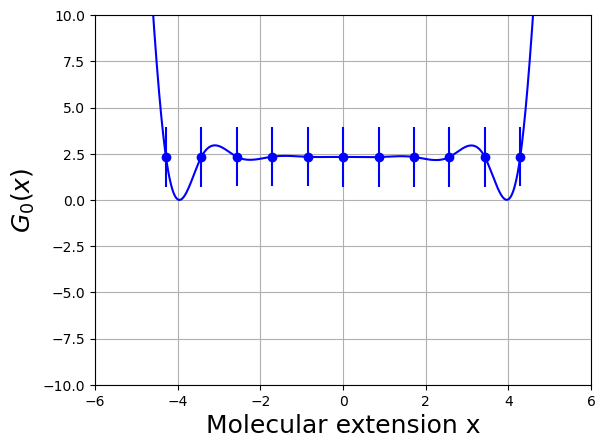

In [7]:
plot_spline_mean_with_error(samples, '../tests/test.config', alpha=0.2)